#### 1) 데이터 불러오기

In [1]:
import torch
import warnings
import time
import random
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm
import matplotlib.pyplot   as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import torch.nn                     as nn
import torch.nn.functional          as F
from   torch.utils.data             import Dataset,DataLoader


# 시드(seed) 고정
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
warnings.filterwarnings(action='ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
# 데이터 파일 경로 설정
df = pd.read_csv('C:/Users/symply_jina/Desktop/seohyun/IIE4123/hw3/LSTM_practice/electricity.csv')

In [3]:
# 하이퍼 파라미터 설정
class Parameters():
    def __init__(self):
        self.description = 'LSTM 모델을 이용한 시계열 예측'
        # 입력 시퀀스 길이 - look-back
        self.Lag         = 30
        # 예측 시퀀스 길이
        self.Horizon     = 7

        # 에포크 수
        self.epochs        = 500
        # 배치 크기
        self.batch_size    = 16
        # 학습률
        self.learning_rate = 1e-4 # 0.0001
        # 훈련된 모델 경로
        self.model_name    = 'LSTM'
        # 파일명
        self.filename              = './LSTM_practice/electricity.csv'
        # 대상 시계열 이름
        self.targetSeries          = 'OT'
        # 훈련 세트 비율
        self.TrainingSetPercentage = 0.8
        # 스케일링 {'Standard', 'MinMax', 'Robust'}
        self.Scaling               = 'Standard'


args = Parameters()

In [4]:
df

,date,supplyT,returnT,volume,energy,flow,Frederikshavn Temperature [2 m elevation corrected],OT
0,2019-08-21 05:00:00,62.552500,41.200000,153128.4,2762320.0,0.678000,12.157285,16.775000
1,2019-08-21 06:00:00,62.297143,43.724286,153128.9,2762340.0,0.589714,12.517284,12.071429
2,2019-08-21 07:00:00,62.051429,47.042857,153129.4,2762340.0,0.510857,12.897284,10.028571
3,2019-08-21 08:00:00,61.840000,45.663750,153129.9,2762360.0,0.429000,13.387284,8.837500
4,2019-08-21 09:00:00,62.202857,43.570000,153130.6,2762370.0,0.812571,13.897284,20.014286
...,...,...,...,...,...,...,...,...
21492,2022-02-01 17:00:00,76.191818,40.070000,173871.3,3384290.0,1.217455,5.197285,50.790909
21493,2022-02-01 18:00:00,76.115000,39.591000,173872.5,3384340.0,1.279200,4.497285,53.970000
21494,2022-02-01 19:00:00,75.956364,38.787273,173873.7,3384390.0,1.217455,3.987285,52.209091
21495,2022-02-01 20:00:00,76.007273,38.352727,173875.0,3384450.0,1.208727,3.637285,52.518182


### Univariate Forecasting

In [5]:
# 날짜로 인식하게 수정 후 데이터프레임으로 변환
df['date'] = df['date'].astype('datetime64[ns]')
df.set_index('date', inplace=True)
df = pd.DataFrame( df[ [ args.targetSeries ] ] )
df

,OT
date,
2019-08-21 05:00:00,16.775000
2019-08-21 06:00:00,12.071429
2019-08-21 07:00:00,10.028571
2019-08-21 08:00:00,8.837500
2019-08-21 09:00:00,20.014286
...,...
2022-02-01 17:00:00,50.790909
2022-02-01 18:00:00,53.970000
2022-02-01 19:00:00,52.209091


In [6]:
# 80% 훈련 나머지 테스트
idx = int( df.shape[0] * args.TrainingSetPercentage )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

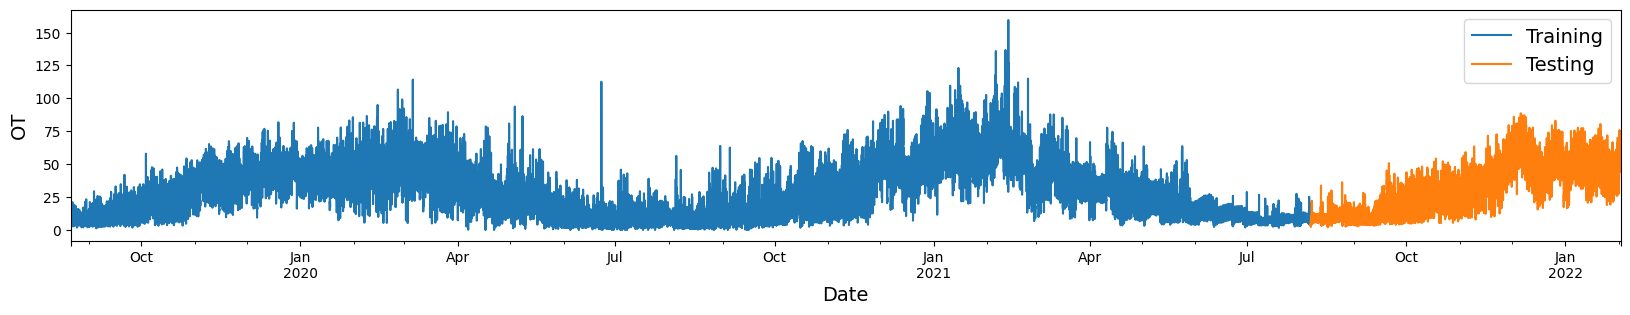

In [7]:
# 학습 및 테스트 데이터 시각화
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train.plot(ax=ax, color='tab:blue' )
df_test.plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], fontsize = 14)
plt.ylabel(args.targetSeries, size = 14);
plt.xlabel('Date', size = 14);

In [8]:
# 테스트 시작시 앞의 과거기간이 필요하므로
# train data의 마지막 날짜로부터 args.Lag 만큼의 데이터를 가져와서 test 앞에 붙임
df_test = pd.concat([df_train.iloc[-args.Lag:], df_test])

In [9]:
if (args.Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')

    scaler = MinMaxScaler()
    df_train[args.targetSeries] = scaler.fit_transform(df_train[args.targetSeries].to_numpy().reshape(-1, 1))
    df_test[args.targetSeries]  = scaler.transform(df_test[args.targetSeries].to_numpy().reshape(-1, 1))

elif (args.Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')


    scaler = RobustScaler()
    df_train[args.targetSeries] = scaler.fit_transform(df_train[args.targetSeries].to_numpy().reshape(-1, 1))
    df_test[args.targetSeries]  = scaler.transform(df_test[args.targetSeries].to_numpy().reshape(-1, 1))

elif (args.Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    scaler = StandardScaler()

    df_train[args.targetSeries] = scaler.fit_transform(df_train[args.targetSeries].to_numpy().reshape(-1, 1))
    df_test[args.targetSeries]  = scaler.transform(df_test[args.targetSeries].to_numpy().reshape(-1, 1))
else:
    print('[WARNING] Unknown data scaling. Standard scaling was selected')

    scaler = StandardScaler()

    df_train[args.targetSeries] = scaler.fit_transform(df_train[args.targetSeries].to_numpy().reshape(-1, 1))
    df_test[args.targetSeries]  = scaler.transform(df_test[args.targetSeries].to_numpy().reshape(-1, 1))

[INFO] Scaling: Standard


In [10]:
def create_dataset(df=None, Lag=1, Horizon=1, targetSeries=None):

    dataX, dataY, dataDate = [], [], []

    # 데이터셋을 생성하기 위한 루프, 0에서 시작해서 데이터프레임의 길이 - Lag - Horizon까지 반복
    for i in tqdm(range(0, df.shape[0] + 1 - Lag - Horizon)):
        # 입력 시퀀스를 dataX에 추가
        dataX.append(df.to_numpy()[i:(i + Lag)])
        # 타겟 시퀀스를 dataY에 추가
        dataY.append(df[targetSeries].to_numpy()[i + Lag : i + Lag + Horizon])
        # 타겟 시퀀스의 날짜를 dataDate에 추가
        dataDate.append(df.index[i + Lag : i + Lag + Horizon].tolist())

    # numpy 배열로 변환하여 반환
    return (np.array(dataX), np.array(dataY), np.array(dataDate))

In [11]:
print(args.Lag, args.Horizon)

30 7


In [13]:
trainX, trainY, _ = create_dataset(df           = df_train,
                                   Lag          = args.Lag,
                                   Horizon      = args.Horizon,
                                   targetSeries = args.targetSeries)


testX,  testY, testDate  = create_dataset(df           = df_test,
                                          Lag          = args.Lag,
                                          Horizon      = args.Horizon,
                                          targetSeries = args.targetSeries)

100%|██████████| 4294/4294 [00:00<00:00, 37333.17it/s]


In [14]:
# 훈련 데이터의 마지막 10%를 검증용으로 사용
#
# 훈련 데이터에서 검증 데이터로 나누는 인덱스를 계산
idx = int(0.9 * trainX.shape[0])

# 검증 데이터셋을 생성 (마지막 10%)
validX, validY = trainX[idx:], trainY[idx:]

# 훈련 데이터셋을 생성 (처음 90%)
trainX, trainY = trainX[:idx], trainY[:idx]
trainY = np.expand_dims(trainY, axis = -1)
validY = np.expand_dims(validY, axis = -1)
testY  = np.expand_dims(testY,  axis = -1)

# 훈련 데이터셋의 형태 출력
print('Training data shape:   ', trainX.shape, trainY.shape)
# 검증 데이터셋의 형태 출력
print('Validation data shape: ', validX.shape, validY.shape)
# 테스트 데이터셋의 형태 출력
print('Testing data shape:    ', testX.shape,  testY.shape)

Training data shape:    (15444, 30, 1) (15444, 7, 1)
Validation data shape:  (1717, 30, 1) (1717, 7, 1)
Testing data shape:     (4294, 30, 1) (4294, 7, 1)


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self, X, Y):
        # 데이터를 torch.tensor로 변환하고 데이터 타입을 float32로 설정
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# 훈련 및 테스트 데이터로더 생성
#
train_ds = Data(trainX, trainY)
valid_ds = Data(validX, validY)
test_ds  = Data(testX,  testY)

# 데이터 로더 준비
#
train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size=args.batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=args.batch_size, shuffle=False)

#### 2) LSTM

In [16]:
import torch.nn as nn
import torch

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_length=24):
        """
        LSTM 모델 초기화

        Args:
            input_size (int): 각 시간 단계별 입력 특징 수. 단일 채널의 경우 1.
            hidden_size (int): 은닉 상태의 특징 수.
            num_layers (int): 순환 레이어 수.
            output_length (int): 출력 시퀀스 길이.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.output_length = output_length
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # batch_first=True: (batch_size, seq_len, input_size) 형태의 입력
        self.fc = nn.Linear(hidden_size, output_length)  # 최종 출력

    def forward(self, x):

        # 초기 은닉 상태 (h0) 및 셀 상태 (c0)를 0으로 초기화
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.hidden_size).to(device)

        # LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, 입력길이, hidden_size)


       # 마지막 시간 단계의 h만 추출하여 fc 통과
        out = self.fc(out[:, -1, :])  # out: (batch_size, output_length)

        return out.unsqueeze(2)  # out: (batch_size, output_length, 1) 형태로 변환


In [17]:
# 모델 생성해서 데이터 넣어보기
model = LSTM(input_size=1, hidden_size=50, num_layers=3, output_length=args.Horizon).to(device)


# 랜덤 입력값 생성 (예: 배치 크기 32, 입력 길이)
input_data = torch.randn(32, args.Lag, 1).to(device)

# 모델 실행 및 출력 확인
output = model(input_data)
print(f"Output shape: {output.shape}")  # (32, 입력 길이, 1) 형태의 출력

Output shape: torch.Size([32, 7, 1])


#### 3) 학습

In [19]:
from EarlyStopping      import *
from LRScheduler        import *


model = LSTM(input_size=1, hidden_size=50, num_layers=3, output_length=args.Horizon).to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(params = model.parameters(),
                             lr     = args.learning_rate)


early_stopping = EarlyStopping(patience  = 10,
                               min_delta = 1e-5)


scheduler = LRScheduler(optimizer = optimizer,
                        patience  = 3,
                        min_lr    = 1e-10,
                        factor    = 0.5)

In [23]:
# 훈련 및 검증 손실 저장
Loss = {
         'Train': [],
         'Valid':  []
       }

# 메인 루프 - 훈련 과정
for epoch in range(1, args.epochs+1):

    # 타이머 시작
    start = time.time()

    # 훈련 손실 모니터링
    train_loss = 0.0
    valid_loss  = 0.0

    ###################
    # 모델 훈련하기 #
    ###################

    for data, target in train_dl:

        #  기울기 초기화
        optimizer.zero_grad()

        data   = data.to(device)
        target = target.to(device)

        outputs = model(data)
        outputs = outputs
        # 손실 계산

        loss = criterion(outputs, target)

        # 기울기 계산
        loss.backward()

        # 업데이트
        optimizer.step()

        train_loss += loss.item() * data.size(0)


    train_loss = train_loss / train_dl.dataset.X.shape[0]

    with torch.no_grad():
        for data, target in valid_dl:

            data   = data.to(device)
            target = target.to(device)

            outputs = model(data)

            # 손실 계산
            loss = criterion(outputs, target)

            # 실행 중인 검증 손실 업데이트
            valid_loss += loss.item() * data.size(0)

    # 평균 훈련 통계 출력
    valid_loss = valid_loss / test_dl.dataset.X.shape[0]

    # 타이머 정지
    stop = time.time()

    # 훈련 결과 출력
    print('\n[INFO] Epoch: {} \tTrain Loss: {:.6f}\tValid Loss: {:.6f} \tTime: {:.2f}secs'.format(epoch, train_loss, valid_loss, stop-start), end=' ')

    # 최적 모델 업데이트
    if (epoch == 1):
        Best_score = valid_loss

        torch.save(model.state_dict(), "./" + args.model_name + ".pth")
        print('(모델 저장됨)\n')
    else:
        if (Best_score > valid_loss):
            Best_score = valid_loss

            torch.save(model.state_dict(), "./" + args.model_name + ".pth")
            print('(모델 저장됨)\n')
        else:
            print('\n')

    # 훈련/검증 손실 저장
    Loss['Train'] += [train_loss]
    Loss['Valid'] += [valid_loss]

    # 학습률 스케줄러
    scheduler(valid_loss)

    # 조기 종료
    if (early_stopping(valid_loss)):
        break


[INFO] Epoch: 1 	Train Loss: 0.604200	Valid Loss: 0.105238 	Time: 13.97secs (모델 저장됨)


[INFO] Epoch: 2 	Train Loss: 0.402146	Valid Loss: 0.070028 	Time: 13.98secs (모델 저장됨)


[INFO] Epoch: 3 	Train Loss: 0.385411	Valid Loss: 0.061184 	Time: 13.67secs (모델 저장됨)


[INFO] Epoch: 4 	Train Loss: 0.374532	Valid Loss: 0.059520 	Time: 14.07secs (모델 저장됨)


[INFO] Epoch: 5 	Train Loss: 0.367731	Valid Loss: 0.059332 	Time: 13.92secs (모델 저장됨)


[INFO] Epoch: 6 	Train Loss: 0.364292	Valid Loss: 0.058703 	Time: 13.90secs (모델 저장됨)


[INFO] Epoch: 7 	Train Loss: 0.362239	Valid Loss: 0.057434 	Time: 13.94secs (모델 저장됨)


[INFO] Epoch: 8 	Train Loss: 0.360734	Valid Loss: 0.055703 	Time: 14.00secs (모델 저장됨)


[INFO] Epoch: 9 	Train Loss: 0.359467	Valid Loss: 0.053744 	Time: 14.08secs (모델 저장됨)


[INFO] Epoch: 10 	Train Loss: 0.358332	Valid Loss: 0.051761 	Time: 13.92secs (모델 저장됨)


[INFO] Epoch: 11 	Train Loss: 0.357283	Valid Loss: 0.049893 	Time: 14.06secs (모델 저장됨)


[INFO] Epoch: 12 	Train Loss: 0.356280	V

In [31]:
# Load best model # 미리 사전훈련한 가중치를 불러와도됨, 주의할점은 모델은 사전훈련했던 모델과 똑같은 구조여야 가중치를 로드할수있음

# 방금 학습에서 가장 낮은 valid loss를 가졌던 epoch의 가중치를 불러오기
model = LSTM(input_size=1, hidden_size=50, num_layers=3, output_length=args.Horizon).to(device)

#model.load_state_dict( torch.load( "./" + args.model_name + ".pth"  ,weights_only=True) )
model.load_state_dict( torch.load( "./" + "LSTM_pretrained.pth" ) )

model.eval()

print('[INFO] Model loaded')

[INFO] Model loaded


In [32]:
# 테스트 데이터 예측
pred = None
with torch.no_grad():
    for data, target in tqdm( test_dl ):
        data   = data.to( device )
        target = target.to( device )
        if pred is None:
            pred = model(data).cpu().numpy()  # 처음 예측 값을 NumPy 배열로 변환
        else:
            pred = np.concatenate([pred, model(data).cpu().numpy()])  # 이후 예측 값들을 연결

100%|██████████| 269/269 [00:00<00:00, 1124.93it/s]


In [33]:
# Reshaping
testY_ = testY.squeeze(-1) # 마지막 차원 제거
pred  = pred.squeeze(-1) # 마지막 차원 제거

In [34]:
testY_.shape

(4294, 7)

In [35]:
pred.shape

(4294, 7)

In [36]:
# Inverse scaling

for i in range( args.Horizon ):
    testY_[:,  i] = scaler.inverse_transform( testY_[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)

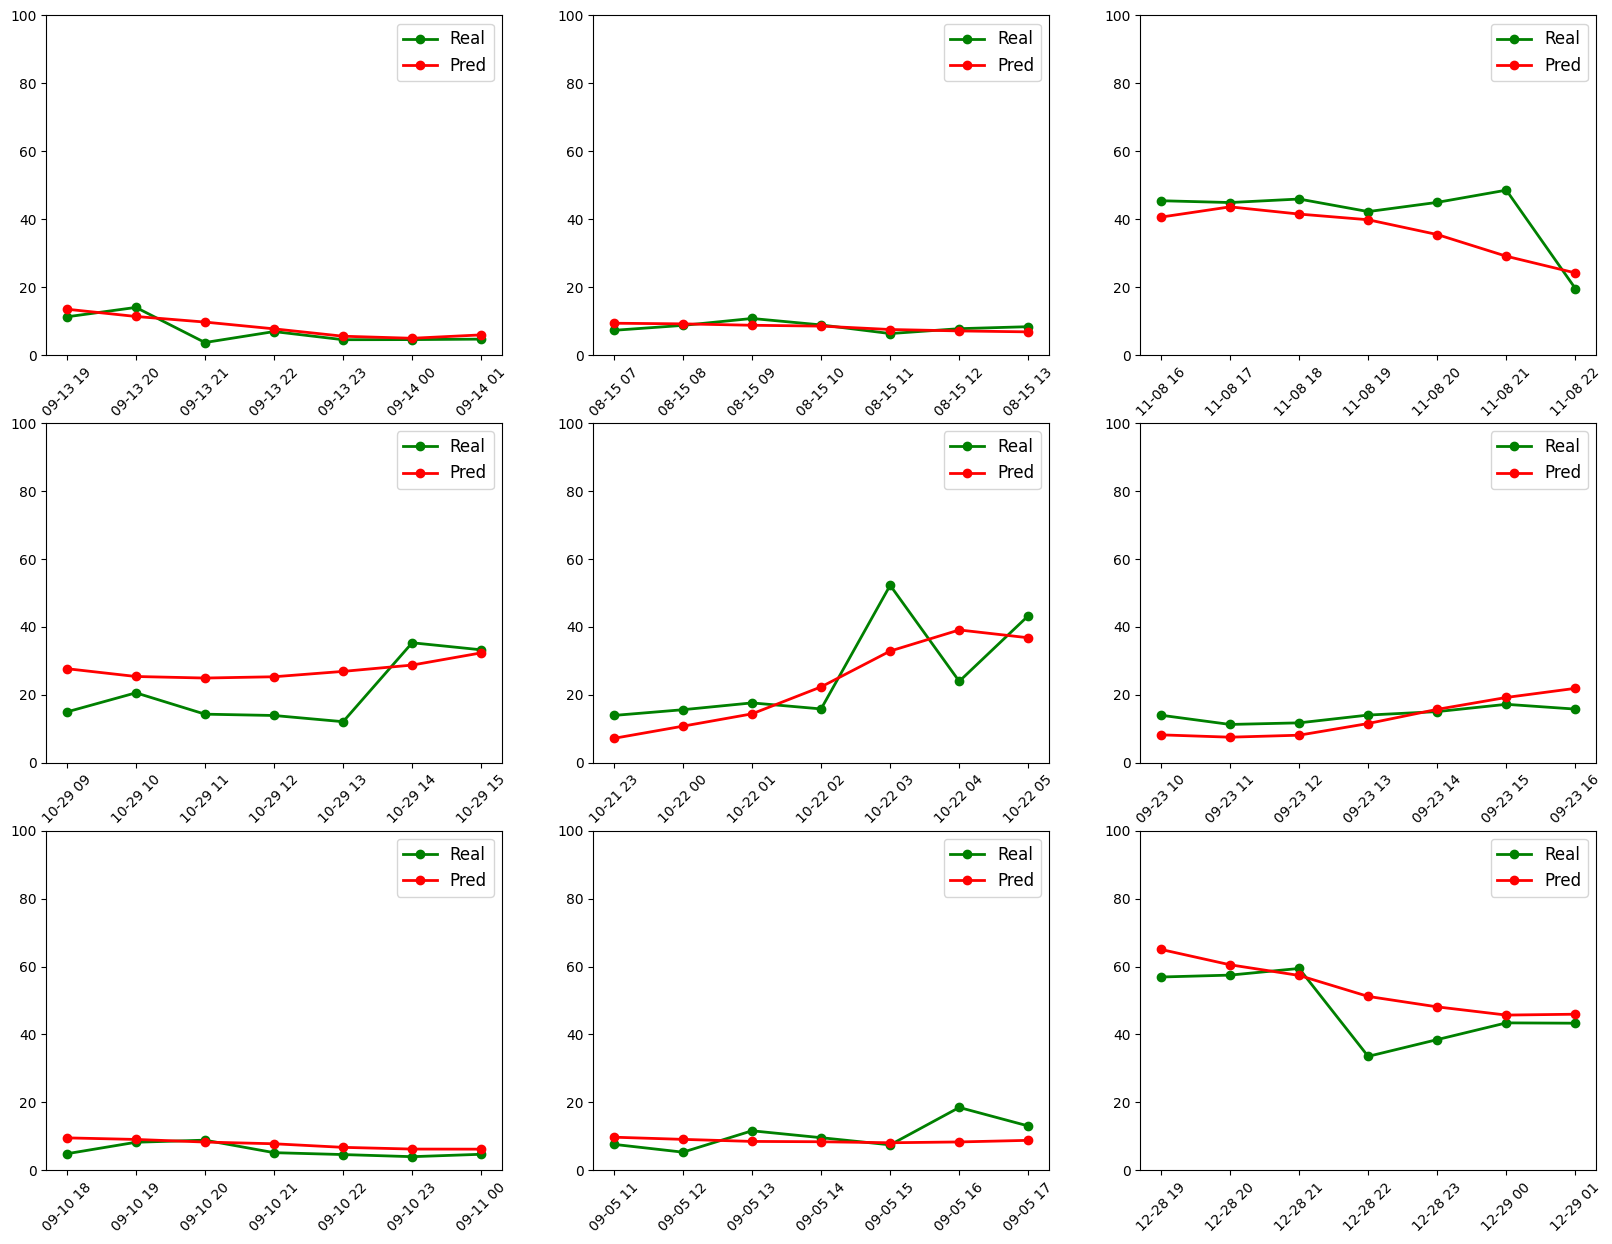

In [37]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]


plt.figure(figsize=(20, 15))

# 랜덤 케이스 선택 (9개만)
RandomInstances = [random.randint(1, testY_.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.plot(testDate[i], testY_[i], color='g', marker='o', linewidth=2)
    plt.plot(testDate[i], pred[i], color='r', marker='o', linewidth=2)

    plt.legend(['Real', 'Pred'], fontsize=12)
    plt.ylim([0, 100])
    plt.xticks(rotation=45)
plt.show()

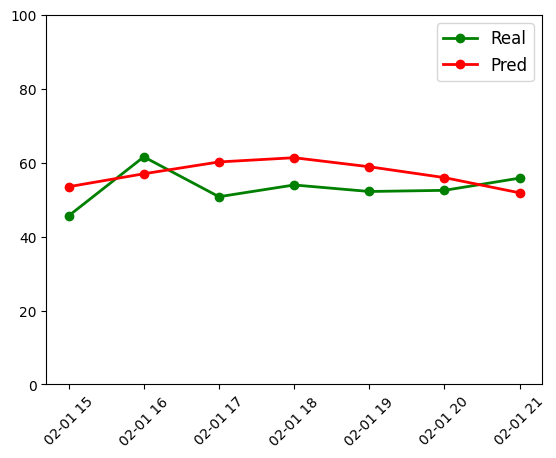

In [38]:
# 가장 최근 예측

plt.plot(testDate[-1], testY_[-1], color='g', marker='o', linewidth=2)
plt.plot(testDate[-1], pred[-1], color='r', marker='o', linewidth=2)

plt.legend(['Real', 'Pred'], fontsize=12)
plt.ylim([0, 100])
plt.xticks(rotation=45)
plt.show()


In [ ]:
# 전체 테스트 데이터에 대한 예측과 실제값 비교
plt.figure(figsize=(15, 8))

plt.plot(range(len(testY_)), testY_, color='g', label='Real', linewidth=2)
plt.plot(range(len(pred)), pred, color='r', label='Predicted', linewidth=2)

plt.title('OT 시계열 trend를 활용하여 OT 예측', fontsize=15)
plt.xlabel('테스트 데이터의 순서', fontsize=12)
plt.ylabel('y label (OT) 값', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
# 테스트 데이터의 MAE 계산
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(testY_, pred)
print(f'테스트 데이터의 Mean Absolute Error (MAE): {mae:.4f}')


In [ ]:
# 실제 값과 예측 값의 산점도 그리기
plt.figure(figsize=(10, 8))
plt.scatter(testY_, pred, alpha=0.5)
plt.plot([0, 100], [0, 100], 'r--')  # 이상적인 예측선 (y=x)

plt.xlabel('실제 값 (real OT)', fontsize=12)
plt.ylabel('예측 값 (predicted OT)', fontsize=12)
plt.title('실제 OT vs 예측 OT 산점도', fontsize=15)

plt.grid(True)
plt.show()

# 경향 분석
print("실제 OT 값이 작을 때는 예측이 비교적 정확한 반면, OT 값이 클수록 예측의 분산이 커지고 정확도가 떨어지는 경향을 보입니다.")




```
# 코드로 형식 지정됨
```

### Multivariate Forecasting

In [5]:
df = pd.read_csv( args.filename )
df

,date,supplyT,returnT,volume,energy,flow,Frederikshavn Temperature [2 m elevation corrected],OT
0,2019-08-21 05:00:00,62.552500,41.200000,153128.4,2762320.0,0.678000,12.157285,16.775000
1,2019-08-21 06:00:00,62.297143,43.724286,153128.9,2762340.0,0.589714,12.517284,12.071429
2,2019-08-21 07:00:00,62.051429,47.042857,153129.4,2762340.0,0.510857,12.897284,10.028571
3,2019-08-21 08:00:00,61.840000,45.663750,153129.9,2762360.0,0.429000,13.387284,8.837500
4,2019-08-21 09:00:00,62.202857,43.570000,153130.6,2762370.0,0.812571,13.897284,20.014286
...,...,...,...,...,...,...,...,...
21492,2022-02-01 17:00:00,76.191818,40.070000,173871.3,3384290.0,1.217455,5.197285,50.790909
21493,2022-02-01 18:00:00,76.115000,39.591000,173872.5,3384340.0,1.279200,4.497285,53.970000
21494,2022-02-01 19:00:00,75.956364,38.787273,173873.7,3384390.0,1.217455,3.987285,52.209091
21495,2022-02-01 20:00:00,76.007273,38.352727,173875.0,3384450.0,1.208727,3.637285,52.518182


In [6]:
# 'date' 열이 있다면 datetime 형식으로 변환
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# 데이터의 80%를 훈련 데이터로 사용하고 나머지는 테스트 데이터로 사용
idx = int(df.shape[0] * args.TrainingSetPercentage)

df_train = df[:idx].dropna().reset_index(drop=True)
df_test = df[idx:].dropna().reset_index(drop=True)

In [7]:
# 테스트 데이터의 시작 부분에 훈련 데이터의 마지막 'Lag' 행을 추가
df_test = pd.concat([df_train.iloc[-args.Lag:], df_test]).reset_index(drop=True)

# 스케일링할 피처 목록을 정의 ('date' 제외)
features_to_scale = df.columns.drop(['date'])

# 스케일링 설정
if args.Scaling == 'MinMax':
    print('[INFO] Scaling: MinMax')
    scaler = MinMaxScaler()
elif args.Scaling == 'Robust':
    print('[INFO] Scaling: Robust')
    scaler = RobustScaler()
else:
    print('[INFO] Scaling: Standard')
    scaler = StandardScaler()

# 훈련 데이터에 스케일러를 핏
df_train[features_to_scale] = scaler.fit_transform(df_train[features_to_scale])

# 동일한 스케일러로 테스트 데이터를 변환
df_test[features_to_scale] = scaler.transform(df_test[features_to_scale])

[INFO] Scaling: Standard


In [8]:
# LSTM 모델을 위한 시퀀스를 생성합니다.
def create_dataset(df, Lag=1, Horizon=1, targetSeries=None, feature_cols=None):
    dataX, dataY, dataDate = [], [], []

    for i in tqdm(range(0, df.shape[0] + 1 - Lag - Horizon)):
        # 입력 시퀀스 X를 선택합니다.
        dataX.append(df[feature_cols].iloc[i:(i + Lag)].to_numpy())
        # 타겟 변수 y를 선택합니다.
        dataY.append(df[targetSeries].iloc[i + Lag : i + Lag + Horizon].to_numpy())
        # 참조를 위한 날짜를 저장합니다.
        dataDate.append(df['date'].iloc[i + Lag : i + Lag + Horizon].tolist())

    return (np.array(dataX), np.array(dataY), np.array(dataDate))

# 피처 컬럼 목록을 정의합니다 ('date' 제외)
feature_cols = df.columns.drop(['date'])

In [9]:
feature_cols

Index(['supplyT', 'returnT', 'volume', 'energy', 'flow',
       'Frederikshavn Temperature [2 m elevation corrected]', 'OT'],
      dtype='object')

In [10]:
# 데이터셋을 생성합니다.
trainX, trainY, _ = create_dataset(df=df_train, Lag=args.Lag, Horizon=args.Horizon,
                                   targetSeries=args.targetSeries, feature_cols=feature_cols)

testX, testY, testDate = create_dataset(df=df_test, Lag=args.Lag, Horizon=args.Horizon,
                                        targetSeries=args.targetSeries, feature_cols=feature_cols)

100%|██████████| 4294/4294 [00:00<00:00, 4704.91it/s]


In [11]:
trainX.shape


(17161, 30, 7)

In [12]:
# 훈련 데이터의 마지막 10%를 검증 데이터로 사용합니다.
idx = int(0.9 * trainX.shape[0])

validX, validY = trainX[idx:], trainY[idx:]
trainX, trainY = trainX[:idx], trainY[:idx]

# 필요에 따라 Y의 차원을 확장합니다.
trainY = np.expand_dims(trainY, axis=-1)
validY = np.expand_dims(validY, axis=-1)
testY = np.expand_dims(testY, axis=-1)

# 데이터셋의 모양을 출력합니다.
print('Training data shape:   ', trainX.shape, trainY.shape)
print('Validation data shape: ', validX.shape, validY.shape)
print('Testing data shape:    ', testX.shape, testY.shape)

Training data shape:    (15444, 30, 7) (15444, 7, 1)
Validation data shape:  (1717, 30, 7) (1717, 7, 1)
Testing data shape:     (4294, 30, 7) (4294, 7, 1)


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self, X, Y):
        # 데이터를 torch.tensor로 변환하고 데이터 타입을 float32로 설정
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# 훈련 및 테스트 데이터로더 생성
#
train_ds = Data(trainX, trainY)
valid_ds = Data(validX, validY)
test_ds  = Data(testX,  testY)

# 데이터 로더 준비
#
train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=args.batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=args.batch_size, shuffle=False)

In [14]:
print(trainX[1,1:30,-1])
print(trainY[1,:,-1])

[-0.9088272  -0.96826401 -0.4105204  -0.78799315 -1.04855271 -0.95641229
 -0.42691676 -0.92950087 -1.02502749 -0.98154149 -0.54525572 -0.85393503
 -1.00221517 -0.77239878 -1.14835664 -1.27328979 -1.20467458 -1.14895072
 -1.20280326 -1.20182304 -0.77979497 -0.84609329 -0.3527767  -0.78692382
 -0.70191225 -0.89385661 -0.8988468  -1.00381916 -0.89314372]
[-0.75341821 -1.01575999 -0.98296726 -0.80795393 -0.89279319 -0.64090204
 -0.83760956]


In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=1, output_length=24):
        """
        LSTM 모델 초기화

        Args:
            input_size (int): 각 시간 단계별 입력 특징 수.
            hidden_size (int): 은닉 상태의 특징 수.
            num_layers (int): 순환 레이어 수.
            output_length (int): 출력 시퀀스 길이.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.output_length = output_length
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_length)

    def forward(self, x):
        # LSTM 레이어 통과 (초기 은닉 상태와 셀 상태는 기본적으로 0으로 초기화됩니다)
        out, _ = self.lstm(x)  # out: (batch_size, seq_length, hidden_size)
        # 마지막 시점의 출력을 사용하여 완전 연결 레이어 통과
        out = self.fc(out[:, -1, :])  # out: (batch_size, output_length)
        return out.unsqueeze(2)  # 출력 형태: (batch_size, output_length, 1)

In [16]:
from EarlyStopping      import *
from LRScheduler        import *

# 피처의 수를 설정합니다 (예: 7개의 피처)
input_size = len(feature_cols)  # feature_cols는 이전에 정의한 피처 목록입니다

# 모델 생성
model = LSTM(input_size=input_size, hidden_size=50, num_layers=3, output_length=args.Horizon).to(device)

# DataLoader에서 데이터 가져오기
for data, target in train_dl:
    print(f"Input data shape: {data.shape}")  # 예상 형태: (배치 크기, 시퀀스 길이, 입력 특징 수)
    print(f"Target data shape: {target.shape}")  # 예상 형태: (배치 크기, 출력 길이, 1)
    break

# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=args.learning_rate)

# 조기 종료 및 학습률 스케줄러 설정
early_stopping = EarlyStopping(patience=10, min_delta=1e-5)
scheduler = LRScheduler(optimizer=optimizer, patience=3, min_lr=1e-10, factor=0.5)


Input data shape: torch.Size([16, 30, 7])
Target data shape: torch.Size([16, 7, 1])


In [17]:
# 훈련 및 검증 손실 저장
Loss = {'Train': [], 'Valid': []}

# 메인 루프 - 훈련 과정
Best_score = None  # Best_score 초기화
for epoch in range(1, args.epochs+1):
    start = time.time()
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    #     모델 훈련    #
    ###################
    model.train()
    for data, target in train_dl:
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_dl.dataset)

    ###################
    #   검증 단계     #
    ###################
    model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            valid_loss += loss.item() * data.size(0)
    valid_loss = valid_loss / len(valid_dl.dataset)

    stop = time.time()
    print(f'\n[INFO] Epoch: {epoch} \tTrain Loss: {train_loss:.6f}\tValid Loss: {valid_loss:.6f} \tTime: {stop - start:.2f} secs', end=' ')

    # 최적 모델 저장
    if epoch == 1 or (Best_score is not None and valid_loss < Best_score):
        Best_score = valid_loss
        torch.save(model.state_dict(), "./" + args.model_name + ".pth")
        print('(모델 저장됨)\n')
    else:
        print('\n')

    # 손실 저장
    Loss['Train'].append(train_loss)
    Loss['Valid'].append(valid_loss)

    # 학습률 스케줄러 업데이트
    scheduler(valid_loss)

    # 조기 종료 체크
    if early_stopping(valid_loss):
        print("[INFO] 조기 종료 조건 만족. 학습을 종료합니다.")
        break


[INFO] Epoch: 1 	Train Loss: 0.464291	Valid Loss: 0.060597 	Time: 14.27 secs (모델 저장됨)


[INFO] Epoch: 2 	Train Loss: 0.346554	Valid Loss: 0.052054 	Time: 14.36 secs (모델 저장됨)


[INFO] Epoch: 3 	Train Loss: 0.339442	Valid Loss: 0.059601 	Time: 14.02 secs 


[INFO] Epoch: 4 	Train Loss: 0.331733	Valid Loss: 0.061541 	Time: 14.21 secs 


[INFO] Epoch: 5 	Train Loss: 0.327969	Valid Loss: 0.059820 	Time: 14.08 secs 


[INFO] Epoch: 6 	Train Loss: 0.324555	Valid Loss: 0.072247 	Time: 14.28 secs 


[INFO] Epoch: 7 	Train Loss: 0.318288	Valid Loss: 0.061611 	Time: 14.31 secs 


[INFO] Epoch: 8 	Train Loss: 0.312131	Valid Loss: 0.063396 	Time: 14.41 secs 


[INFO] Epoch: 9 	Train Loss: 0.302309	Valid Loss: 0.063238 	Time: 14.01 secs 


[INFO] Epoch: 10 	Train Loss: 0.291922	Valid Loss: 0.061220 	Time: 14.20 secs 


[INFO] Epoch: 11 	Train Loss: 0.283579	Valid Loss: 0.061118 	Time: 14.10 secs 


[INFO] Epoch: 12 	Train Loss: 0.278999	Valid Loss: 0.059642 	Time: 13.96 secs 

[INFO] Early stopping

In [18]:
# 최적 모델 로드
model.load_state_dict(torch.load("./" + args.model_name + ".pth"))
model.eval()
print('[INFO] 최적 모델이 로드되었습니다.')

[INFO] 최적 모델이 로드되었습니다.


In [19]:
import numpy as np
import torch

# 테스트 데이터 예측
test_predictions = []
test_targets = []
with torch.no_grad():
    for data, target in tqdm(test_dl):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        test_predictions.append(output.cpu().numpy())
        test_targets.append(target.cpu().numpy())

# 예측값과 실제값을 배열로 연결
test_predictions = np.concatenate(test_predictions, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# 출력 형태 확인
print(f"Predictions shape: {test_predictions.shape}")
print(f"Targets shape: {test_targets.shape}")

# 필요한 경우 출력 차원 조정
test_predictions = test_predictions.reshape(-1, args.Horizon)
test_targets = test_targets.reshape(-1, args.Horizon)


100%|██████████| 269/269 [00:01<00:00, 203.19it/s]

Predictions shape: (4294, 7, 1)
Targets shape: (4294, 7, 1)


In [20]:
# 피처의 수와 대상 변수의 인덱스 찾기
num_features = len(feature_cols)
feature_cols_list = list(feature_cols)
target_index = feature_cols_list.index(args.targetSeries)

# 예측값과 실제값을 평탄화
n_samples = test_predictions.shape[0]
test_predictions_flat = test_predictions.flatten().reshape(-1, 1)
test_targets_flat = test_targets.flatten().reshape(-1, 1)

# 역스케일링을 위한 배열 생성
pred_full = np.zeros((n_samples * args.Horizon, num_features))
target_full = np.zeros((n_samples * args.Horizon, num_features))

# 대상 변수 위치에 예측값과 실제값을 삽입
pred_full[:, target_index] = test_predictions_flat.squeeze()
target_full[:, target_index] = test_targets_flat.squeeze()

# 역스케일링 수행
pred_inv_flat = scaler.inverse_transform(pred_full)[:, target_index]
target_inv_flat = scaler.inverse_transform(target_full)[:, target_index]

# 원래 형태로 재조정
test_predictions_inv = pred_inv_flat.reshape(n_samples, args.Horizon)
test_targets_inv = target_inv_flat.reshape(n_samples, args.Horizon)


In [21]:
# MAE 계산
from sklearn.metrics import mean_absolute_error

# 전체 시퀀스에 대한 MAE 계산
mae = mean_absolute_error(test_targets_inv, test_predictions_inv)

print(f"테스트 데이터의 평균 절대 오차 (MAE): {mae:.2f}")


테스트 데이터의 평균 절대 오차 (MAE): 8.91


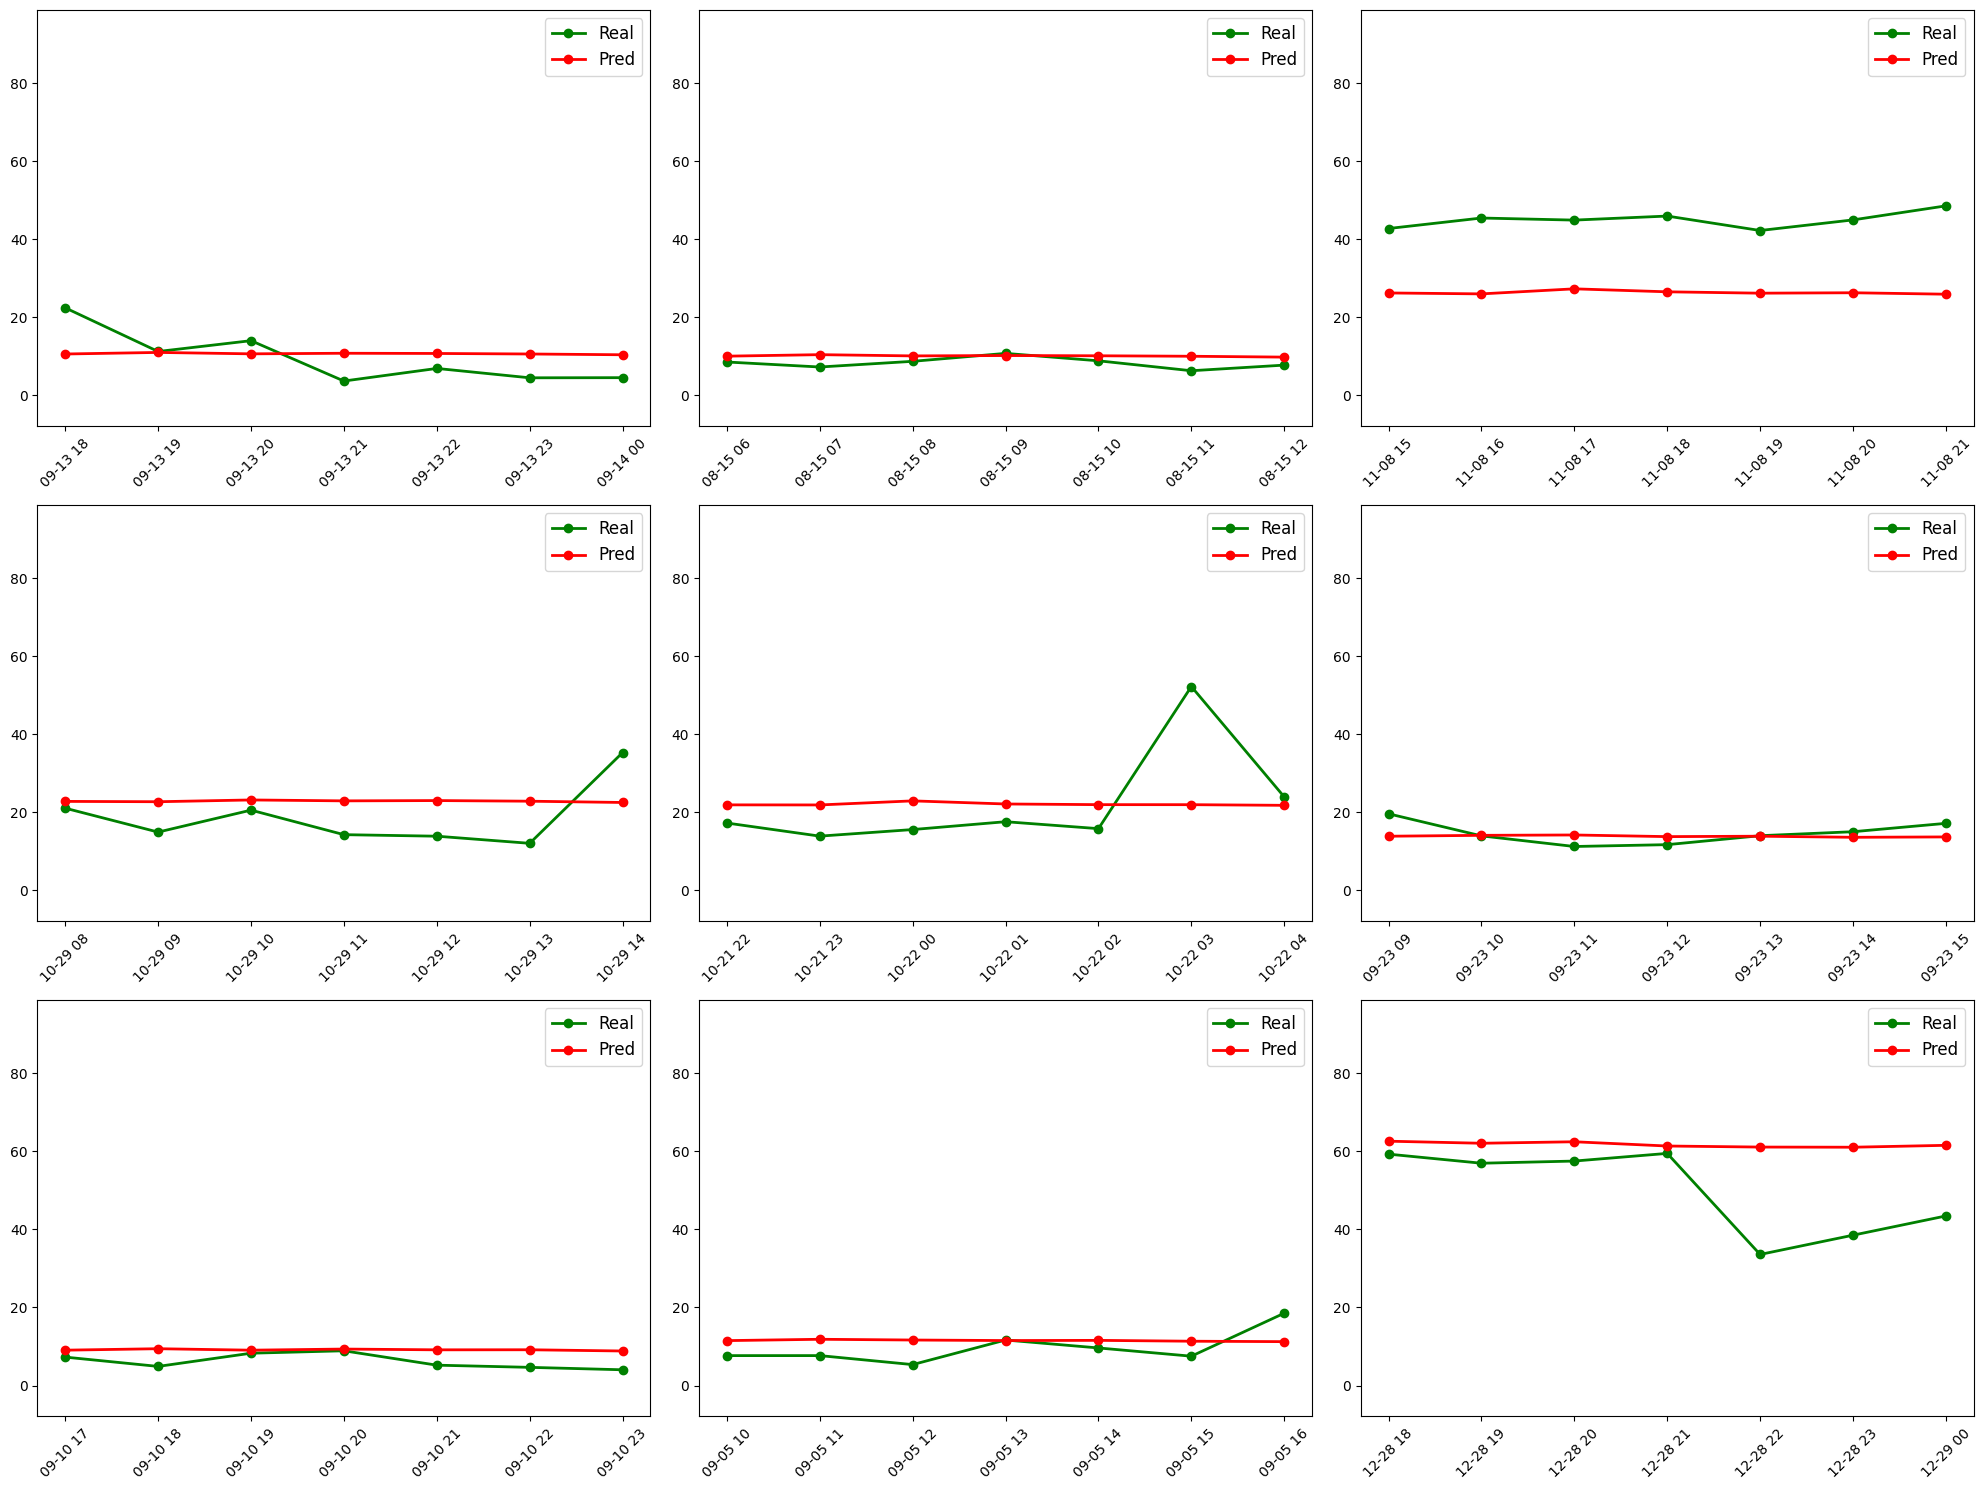

In [22]:
import matplotlib.pyplot as plt
import random

# 서브플롯 설정
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]

plt.figure(figsize=(20, 15))

# 랜덤 케이스 선택 (9개만)
RandomInstances = [random.randint(0, n_samples - 1) for _ in range(9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.plot(testDate[i], test_targets_inv[i], color='g', marker='o', linewidth=2)
    plt.plot(testDate[i], test_predictions_inv[i], color='r', marker='o', linewidth=2)

    plt.legend(['Real', 'Pred'], fontsize=12)
    plt.ylim([min(test_targets_inv.min(), test_predictions_inv.min()) - 10,
              max(test_targets_inv.max(), test_predictions_inv.max()) + 10])
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
